# Mask R-CNN

Code and visualizations to test, debug and evaluate the Mask R-CNN model.

We start the model with a weights file that has been trained on the COCO dataset.
The COCO dataset does not contain C Eelegans, but a lot of other images, so that the weights have learned a lot of features already.
It would be possible to train a model from scratch but this is out of scope fpr this project.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

/Users/imkeschwenke/Programmieren/InstanceSegmentation/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# root directory of the project
ROOT_DIR = './'

import mrcnn.utils
import mrcnn.visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import CElegansDataset


COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_coco.h5")

In [3]:
from cElegans import CElegansConfig
config = CElegansConfig()
CELEGANS_DIR = os.path.join(ROOT_DIR, "dataset")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
from cElegans import CElegansDataset

# Load Training dataset
dataset = CElegansDataset()
dataset.load_c_elegans(CELEGANS_DIR, "train")
dataset.prepare()

datatset_val = CElegansDataset()
datatset_val.load_c_elegans(CELEGANS_DIR, "val")
datatset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 214
Classes: ['BG', 'c_elegans']


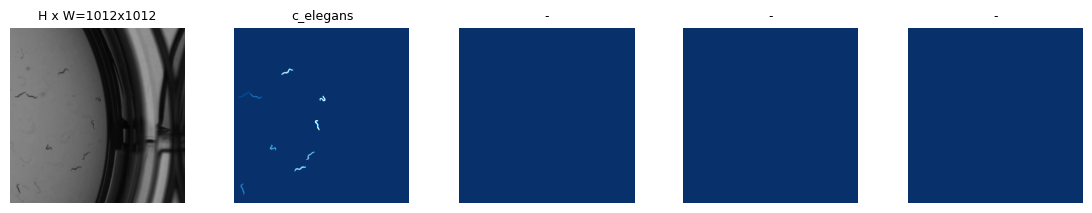

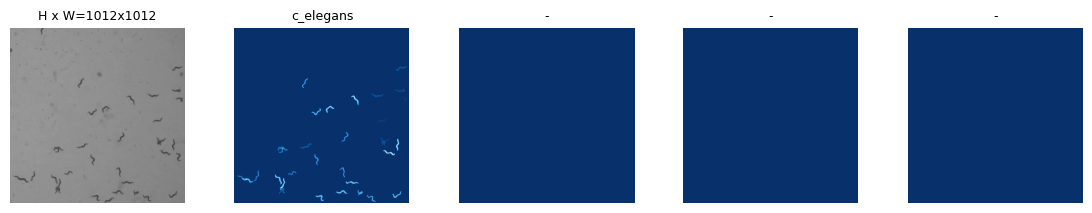

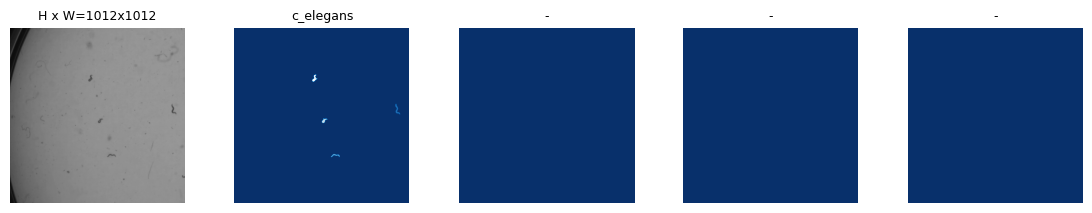

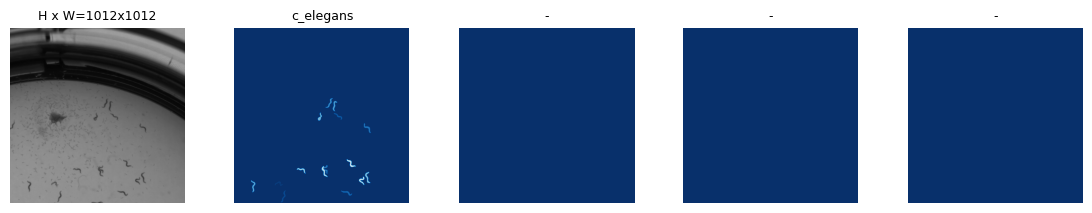

In [8]:
from mrcnn import visualize
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

### Load Model

In [9]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [10]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

94653016/94653016 [==============================] - 5s 0us/step


2024-09-11 11:54:37.830740: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-09-11 11:54:37.881341: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'proposal_targets/cond/output/_16'


In [14]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset, datatset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs/c_elegans20240905T1150/mask_rcnn_c_elegans_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistrib

/Users/imkeschwenke/Programmieren/Uni/Master/InstanceSegmentation/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-09-05 11:50:23.654392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-05 11:50:23.654412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-05 11:50:23.854094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 11:50:24.116666: W tensorflow/c/c_api.cc:304] Operation '{

KeyboardInterrupt: 

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset, datatset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: ./logs/c_elegans20240905T0040/mask_rcnn_c_elegans_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b          

/Users/imkeschwenke/Programmieren/Uni/Master/InstanceSegmentation/.venv/lib/python3.9/site-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2024-09-05 00:49:30.030090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 00:49:30.103228: W tensorflow/c/c_api.cc:304] Operation '{name:'range_10' id:14218 op device:{requested: '', assigned: ''} def:{{{node range_10}} = Range[Tidx=DT_INT32, _has_manual_control_dependencies=true](range_10/start, Rank_10, range_10/delta)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-05 00:49:30.515808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plu

Epoch 2/2


2024-09-05 00:50:33.422055: W tensorflow/c/c_api.cc:304] Operation '{name:'loss_1/AddN' id:16526 op device:{requested: '', assigned: ''} def:{{{node loss_1/AddN}} = AddN[N=10, T=DT_FLOAT, _has_manual_control_dependencies=true](mul, mul_1, mul_2, mul_3, mul_4, mul_52, mul_53, mul_54, mul_55, mul_56)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-09-05 00:50:33.800247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-05 00:50:34.027143: W tensorflow/c/c_api.cc:304] Operation '{name:'training_2/SGD/bn4a_branch2a/gamma/momentum/Assign' id:20158 op device:{requested: '', assigned: ''} def:{{{node training_2/SGD/bn4a_branch2a/gamma/momentum/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=fa

  1/100 [..............................] - ETA: 3:06:52 - batch: 0.0000e+00 - size: 1.0000 - loss: 6.3442 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 2.2737 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.5551 - mrcnn_mask_loss: 0.2669

2024-09-05 00:52:24.028210: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-09-05 00:52:24.028226: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


  2/100 [..............................] - ETA: 17:27 - batch: 0.5000 - size: 1.0000 - loss: 10.6415 - rpn_class_loss: 0.1026 - rpn_bbox_loss: 2.6434 - mrcnn_class_loss: 0.0949 - mrcnn_bbox_loss: 1.8896 - mrcnn_mask_loss: 0.5903     

2024-09-05 00:52:34.494468: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2024-09-05 00:52:34.535526: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2024-09-05 00:52:34.538786: I tensorflow/tsl/profiler/rpc/client/save_profile.cc:144] Collecting XSpace to repository: ./logs/c_elegans20240905T0040/plugins/profile/2024_09_05_00_52_34/Air-von-Imke.xplane.pb


 72/100 [====================>.........] - ETA: 3:29 - batch: 35.5000 - size: 1.0000 - loss: 5.8771 - rpn_class_loss: 0.2070 - rpn_bbox_loss: 1.3142 - mrcnn_class_loss: 0.3783 - mrcnn_bbox_loss: 0.6777 - mrcnn_mask_loss: 0.3613

RuntimeError: generator raised StopIteration

In [ ]:
# Speichere die trainierten Gewichte
model_path = "./mask_rcnn_custom.h5"
model.keras_model.save_weights(model_path)